====== Nguồn http://users.soict.hust.edu.vn/khoattq/ml-dm-course/ ======


# Bài toán phân loại sử dụng SVM 

Mục tiêu: 
- Xây dựng được mô hình svm sử dụng thư viện sklearn. 
- Ứng dụng, hiểu cách áp dụng mô hình SVM vào giải quyết bài toán thực tế (Ví dụ: phân loại văn bản) 
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 

Dữ liệu: 
- Có tập các văn bản và nhãn tương ứng của từng văn bản trong một khoảng thời gian 
- Tập các nhãn (10 nhãn khác nhau): 
    > Giải trí, Khoa học - Công nghệ, Kinh tế, Pháp luật, Sức khỏe, Thể thao, Thời sự, Tin khác, Độc giả, Đời sống - Xã hội
- Ví dụ văn bản nhãn **thể thao**: 
    > "Dân_trí Real Madrid đã dẫn trước trong cả trận đấu , nhưng họ vẫn phải chấp_nhận bị Dortmund cầm hòa 2-2 ở Bernabeu . Real Madrid chấp_nhận đứng thứ_hai ở bảng F Champions League ..."

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

%matplotlib inline

## 1. Load dữ liệu từ thư mục đã thu thập từ trước 

Giả sử cấu trúc thư mục như sau 

- data/news_1135/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [9]:
DATA_PATH = "data/news_vnexpress/"
header = "%-20s%-30s" % ("Số lượng văn bản", "Nhãn")
print(header)
print("---------------------------------------------")
total = 0
for label in os.listdir(DATA_PATH):
    n = len(os.listdir(os.path.join(DATA_PATH, label)))
    total += n
    entry = "%-20d%-30s" % (n, label)
    print(entry)
print("---------------------------------------------")
print(f'Tổng số văn bản: {total}')

Số lượng văn bản    Nhãn                          
---------------------------------------------
120                 doi-song                      
54                  du-lich                       
180                 giai-tri                      
---------------------------------------------
Tổng số văn bản: 354


In [11]:
data_train = load_files(container_path=DATA_PATH, encoding="utf-8")
print(dir(data_train))

['DESCR', 'data', 'filenames', 'target', 'target_names']


In [13]:
header = "%-6s %-10s" % ("ID", "Nhãn")
print(header)
print("---------------------------------------------")
for id, label in enumerate(data_train.target_names):
    print("%-6d %-10s" % (id, label))

ID     Nhãn      
---------------------------------------------
0      doi-song  
1      du-lich   
2      giai-tri  


In [15]:
print(data_train.data[0:2], end='\n\n')
print(data_train.filenames[0:2], end='\n\n')
print(data_train.target[0:2], end='\n\n')

['Nhân ngày lễ tình nhân 14/2, Viktoria Pustovitova, 28 tuổi và Alexander Kudlay, 33 tuổi, quyết định xích tay nhau ba tháng để thử thách tình yêu.Sau khi "chung xích", đôi tình nhân ở Kharkiv tin rằng họ có thể cùng nhau vượt qua mọi sự bất tiện trong sinh hoạt, từ rửa bát, nấu thức ăn đến đi vệ sinh và lái xe ô tô.Tuy nhiên, hôm 26/2, truyền thông Ukraine đưa tin, sợi xích đã khiến cô Viktoria bị loét cổ tay. "Chúng tôi đã bôi thuốc nhưng không được. Đó quả là một cơn ác mộng", cô gái nói.Họ buộc phải đến bệnh viện để xử lý vết thương ở cổ tay.Bác sĩ da liễu Tatyana Egorova cảnh báo, đôi tình nhân có thể phải từ bỏ thử thách tình yêu. "Đây là vết loét do tiếp xúc lâu với kim loại. Các mô da bị kẹp liên tục nên dẫn đến rối loạn tuần hoàn", bác sĩ này nói.Viktoria và Alexander có thể làm mọi việc hàng ngày cùng nhau. Tuy nhiên, vào nhà vệ sinh công cộng khiến họ gặp chút rắc rối. Viktoria muốn dùng nhà vệ sinh nữ, nhưng cô bị mọi người tỏ thái độ khó chịu khi đưa cả bạn trai đi cùng.Al

In [17]:
"""Bài tập
 - Kiểm tra các thông tin sau:
    + Số lượng văn bản trong data_train.data
    + Số lượng ids trong data_train.target
    + Số lượng filenames trong data_train.filenames
"""
###############
###############

'Bài tập\n - Kiểm tra các thông tin sau:\n    + Số lượng văn bản trong data_train.data\n    + Số lượng ids trong data_train.target\n    + Số lượng filenames trong data_train.filenames\n'

###  Tiền xử lý dữ liệu: đưa dữ liệu từ dạng text về dạng ma trận bằng TF-IDF

- Thử nghiệm để kiểm tra hoạt động chuyển hoá dữ liệu về dạng ma trận 

In [20]:
# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt", encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]
print(f"Tổng số lượng từ dừng: {len(stopwords)}")
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[:10])
print()

"""
Chuyển hoá dữ liệu text về dạng vector tfidf 
    - loại bỏ từ dừng
    - sinh từ điển
    - chuyển thành dữ liệu dạng ma trận 2 chiều kích thước n x m với n là số lượng văn bản và m là số lượng từ trong từ điển
"""
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print("5 từ đầu tiên trong từ điển:\n")
i = 0
for k,v in module_count_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 5:
        break 
print()

# Số chiều của dữ liệu 
print(f"Số chiều của dữ liệu: {data_preprocessed.shape}")
print(f"Số từ trong từ điển: {len(module_count_vector.vocabulary_)}")

Tổng số lượng từ dừng: 2063
Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

5 từ đầu tiên trong từ điển:

1 :  ('nhân', 3767)
2 :  ('lễ', 3140)
3 :  ('tình', 5521)
4 :  ('14', 45)
5 :  ('viktoria', 5728)
6 :  ('pustovitova', 4294)

Số chiều của dữ liệu: (354, 6413)
Số từ trong từ điển: 6413


### Chia dữ liệu thành 2 phần train_data và test_data
- train_data chiếm 80 % dữ liệu 
- test_data chiếm 20 % dữ liệu 

In [23]:
from sklearn.model_selection import ShuffleSplit

# chia dữ liệu thành 2 phần sử dụng hàm train_test_split.
test_size = 0.2
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split( data_preprocessed, data_train.target, test_size=test_size)


# hiển thị một số thông tin về dữ liệu 
print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

Dữ liệu training =  (283, 6413) (283,)
Dữ liệu testing =  (71, 6413) (71,)


In [25]:
"""Bài tập
 - Hiển thị ra id, tên nhãn của 5 văn bản đầu tiên trong tập train. 
 - Gợi ý: lấy dữ liệu id từ biến y_train, mapping với thứ tự nằm trong mảng data_train.target_names
"""
###############
###############

'Bài tập\n - Hiển thị ra id, tên nhãn của 5 văn bản đầu tiên trong tập train. \n - Gợi ý: lấy dữ liệu id từ biến y_train, mapping với thứ tự nằm trong mảng data_train.target_names\n'

## 2. Huấn luyện mô hình SVM trên tập train_data

Sử dụng thư viện sklearn để xây dựng mô hình 
- `svm.SVC(kernel='linear', C=1.0)`: chọn hàm nhân phân tách là linear, tham số C=1.0 

In [28]:
print("- Training ...")


# X_train.shape
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)

print("- model - train complete")


- Training ...
- Train size = (283, 6413)
- model - train complete


## 3. Đánh giá mô hình SVM trên tập test_data

Thực hiện dự đoán nhãn cho từng văn bản trong tập test_data 

Độ đo đánh giá: 
> accuracy = tổng số văn bản dự đoán đúng  / tổng số văn bản có trong tập test_data  

In [31]:
from sklearn.metrics import accuracy_score
print("- Testing ...")
y_pred = model.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))


- Testing ...
- Acc = 0.9436619718309859


### Sử dụng model đã được huấn luyện để phán đoán 1 văn bản mới 
- Dữ liệu mới đến ở dạng dữ liệu thô => cần tiền xử lý dữ liệu về dạng dữ_liệu_ma_trận
- Phán đoán bằng hàm model.predict(dữ_liệu_ma_trận) 

In [34]:
# tiền xử lý dữ liệu sử dụng module model_rf_preprocess. 
news = ["Công_phượng ghi bàn cho đội_tuyển Việt_nam"]
preprocessed_news = model_rf_preprocess.transform(news)
print(preprocessed_news, end='\n\n')
# phán đoán nhãn
pred = model.predict(preprocessed_news)
print(pred, data_train.target_names[pred[0]])

  (0, 1868)	0.677407397425015
  (0, 717)	0.7356080599843013

[2] giai-tri


## 4. Bài tập bổ sung: 

### 4.1 Thử nghiệm các tham số 

- Các tham số với giá trị khác nhau có thể ảnh hưởng để kết quả học 
- Cần thử nghiệm kỹ lượng để đưa ra kết quả khách quan: tham số C, kernel.
    - Chọn mô hình với bộ tham số cho kết quả tốt nhất 

In [37]:
"""Bài tập
 - Đánh giá các tham số của mô hình SVM: kernel, C
 - Gợi ý:
     + Đầu tiên cố định C = 1.0 (có thể là giá trị khác), thay đổi kernel = {'linear', 'poly', 'rbf', 'sigmoid'}
     + Với mỗi kernel chạy huấn luyện và đánh giá lại mô hình. Chọn kernel cho acc cao nhất.
       Giả sử trong trường hợp này là linear
     + Cố định kernel là linear, thay đổi C = {0.1, 1.0, 5.0, 10.0}
     + Với mỗi giá trị C chạy huấn luện và đánh giá lại. Chọn C cho acc cao nhất.
"""
######################

######################

"Bài tập\n - Đánh giá các tham số của mô hình SVM: kernel, C\n - Gợi ý:\n     + Đầu tiên cố định C = 1.0 (có thể là giá trị khác), thay đổi kernel = {'linear', 'poly', 'rbf', 'sigmoid'}\n     + Với mỗi kernel chạy huấn luyện và đánh giá lại mô hình. Chọn kernel cho acc cao nhất.\n       Giả sử trong trường hợp này là linear\n     + Cố định kernel là linear, thay đổi C = {0.1, 1.0, 5.0, 10.0}\n     + Với mỗi giá trị C chạy huấn luện và đánh giá lại. Chọn C cho acc cao nhất.\n"

### 4.2 Phân loại số viết tay

Dữ liệu training =  (1437, 64) (1437,)
Dữ liệu testing =  (360, 64) (360,)


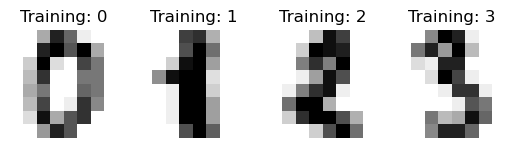

In [40]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
target = digits.target
X_train, X_test, y_train, y_test = train_test_split( data, target, test_size=test_size)

print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

In [42]:
"""Bài tập
 - Đánh giá các tham số của mô hình SVM với bài toán phân loại ảnh
 - Gợi ý: Làm tương tự với phân loại văn bản phía trên
"""
######################
print("- Training ...")


# X_train.shape
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)

print("- model - train complete")

from sklearn.metrics import accuracy_score
print("- Testing ...")
y_pred = model.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))

######################

- Training ...
- Train size = (1437, 64)
- model - train complete
- Testing ...
- Acc = 0.9833333333333333
